This notebook aims to build a model on the Breast Cancer IDC histopathology images.

Change log:
- Try different architecture like DenseNet

In [1]:
%matplotlib inline 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
import matplotlib as plt
import matplotlib.pyplot as pyplt
import matplotlib.image as mpimg
from skimage import io

In [3]:
import wget
import time
import os
import copy

In [4]:
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

In [5]:
import fastai
from fastai.vision.image import *
from fastai.vision import *
from fastai.metrics import *

In [6]:
fastai.__version__

'1.0.60'

In [7]:
data_root = "/home/ubuntu/datasets/breast-histopathology-images/"

In [8]:
!ls -l $data_root | head -5

total 3283148
drwxr-xr-x   4 ubuntu ubuntu       4096 Feb  2 17:51 10253
drwxr-xr-x   4 ubuntu ubuntu       4096 Feb  2 17:51 10254
drwxr-xr-x   4 ubuntu ubuntu       4096 Feb  2 17:51 10255
drwxr-xr-x   4 ubuntu ubuntu       4096 Feb  2 17:51 10256
ls: write error: Broken pipe


In [9]:
!ls -l $data_root | tail -5

drwxr-xr-x   4 ubuntu ubuntu       4096 Feb  2 17:52 9382
drwxr-xr-x   4 ubuntu ubuntu       4096 Feb  2 17:52 9383
-rw-rw-r--   1 ubuntu ubuntu 3326820824 Jan 31 15:54 breast-histopathology-images.zip
drwxr-xr-x 281 ubuntu ubuntu      12288 Feb  2 17:52 IDC_regular_ps50_idx5
-rw-r--r--   1 ubuntu ubuntu   33957737 Feb 18 22:20 train_labels.csv


### Create the databunch

This section extensively uses code from Amerii's kernel from here: https://www.kaggle.com/amerii/breast-cancer-classification-end-to-end

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [11]:
additional_aug=[*zoom_crop(scale=(0.95,1.05), do_rand=False), 
#                     brightness(change=(0.05, 0.05))
#                     contrast(scale=(0.6, 1.4), p=0.75)
                   ]
tfms = get_transforms(dihedral_affine(),max_lighting=0.2, max_zoom=1.1, xtra_tfms=additional_aug)

In [12]:
fnames=get_files(data_root, recurse=True)
fnames[:5], fnames[-5:]

([PosixPath('/home/ubuntu/datasets/breast-histopathology-images/train_labels.csv'),
  PosixPath('/home/ubuntu/datasets/breast-histopathology-images/breast-histopathology-images.zip'),
  PosixPath('/home/ubuntu/datasets/breast-histopathology-images/10273/1/10273_idx5_x2051_y1451_class1.png'),
  PosixPath('/home/ubuntu/datasets/breast-histopathology-images/10273/1/10273_idx5_x2751_y1401_class1.png'),
  PosixPath('/home/ubuntu/datasets/breast-histopathology-images/10273/1/10273_idx5_x1251_y1701_class1.png')],
 [PosixPath('/home/ubuntu/datasets/breast-histopathology-images/9036/0/9036_idx5_x1801_y451_class0.png'),
  PosixPath('/home/ubuntu/datasets/breast-histopathology-images/9036/0/9036_idx5_x2051_y2051_class0.png'),
  PosixPath('/home/ubuntu/datasets/breast-histopathology-images/9036/0/9036_idx5_x951_y2451_class0.png'),
  PosixPath('/home/ubuntu/datasets/breast-histopathology-images/9036/0/9036_idx5_x1051_y2001_class0.png'),
  PosixPath('/home/ubuntu/datasets/breast-histopathology-image

In [13]:
fnames.pop(0)
fnames.pop(0)
fnames[:5]

[PosixPath('/home/ubuntu/datasets/breast-histopathology-images/10273/1/10273_idx5_x2051_y1451_class1.png'),
 PosixPath('/home/ubuntu/datasets/breast-histopathology-images/10273/1/10273_idx5_x2751_y1401_class1.png'),
 PosixPath('/home/ubuntu/datasets/breast-histopathology-images/10273/1/10273_idx5_x1251_y1701_class1.png'),
 PosixPath('/home/ubuntu/datasets/breast-histopathology-images/10273/1/10273_idx5_x2351_y1001_class1.png'),
 PosixPath('/home/ubuntu/datasets/breast-histopathology-images/10273/1/10273_idx5_x1951_y1001_class1.png')]

In [14]:
pattern= r'([^/_]+).png'
data = ImageDataBunch.from_name_re(data_root, fnames, pattern, ds_tfms=tfms, size=50, bs=256,num_workers=4
                                  ).normalize()

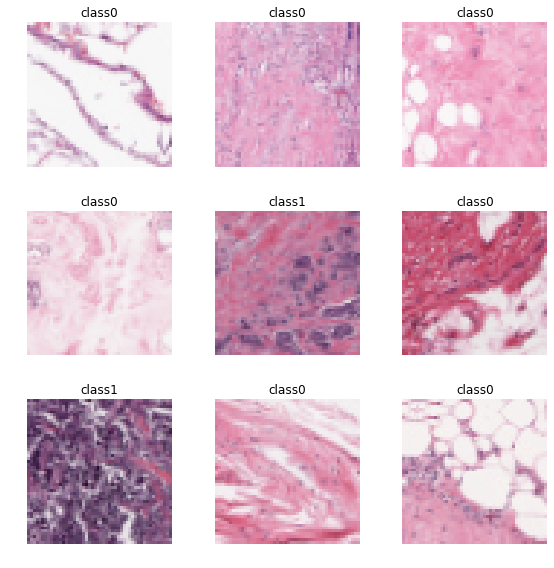

In [15]:
data.show_batch(rows=3, figsize=(8,8))

In [18]:
from fastai.torch_core import nn

In [19]:
# Focal loss : https://github.com/MyLtYkRiTiK/Signate-Tobacco/blob/c50a68900dae4bbddaaa6294c089bfff68ce37d3/scr/training.py

class FocalLoss(fastai.torch_core.nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

In [29]:
import warnings
warnings.filterwarnings('ignore')

__PART 1: DenseNet121__

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


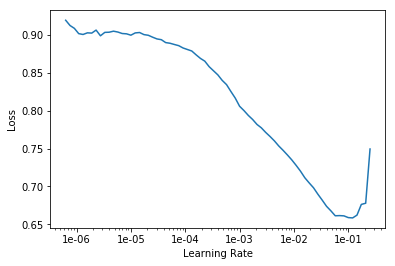

In [30]:
arch = models.densenet121

learn= cnn_learner(data, arch, metrics=[accuracy, error_rate], model_dir='/home/ubuntu/outputs/working/')

learn.lr_find()
learn.recorder.plot()

In [22]:
lr = 1e-2

learn.loss_fn = FocalLoss(gamma = 4)
learn.crit = FocalLoss(gamma = 4)

learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.310611,0.396530,0.837256,0.162744,02:47
1,0.292399,0.318262,0.863894,0.136106,02:43
2,0.276964,0.274905,0.887135,0.112865,02:45
3,0.258848,0.261891,0.890748,0.109252,02:45
4,0.249849,0.268356,0.887081,0.112919,02:46


epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


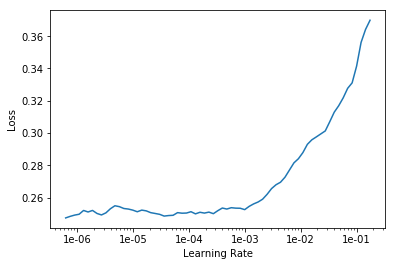

In [23]:
learn.unfreeze()

learn.lr_find()
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(4,slice(1e-6,1e-5))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.245883,0.267724,0.887577,0.112423,03:39
1,0.249864,0.265582,0.888559,0.111441,03:39
2,0.240165,0.264614,0.888775,0.111225,03:39
3,0.247082,0.268366,0.887180,0.112820,03:40


In [25]:
learn.freeze_to(-4)

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


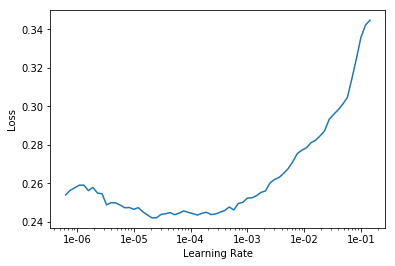

In [26]:
learn.lr_find()
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(4,slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.243031,0.259992,0.890531,0.109469,03:39
1,0.239168,0.260562,0.889477,0.110523,03:39
2,0.240915,0.261541,0.889955,0.110045,03:38
3,0.234612,0.256728,0.892090,0.107910,03:53


In [28]:
learn.freeze_to(-2)
learn.fit_one_cycle(4,slice(1e-6,1e-5))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.238106,0.255684,0.892477,0.107523,03:25
1,0.230846,0.256463,0.892207,0.107793,03:26
2,0.237203,0.258171,0.891234,0.108766,03:21
3,0.235404,0.253377,0.893378,0.106622,03:27


### Conclusion

Conclusion after the exploration: Changing ResNet with DenseNet did not help. We get almost the same accuracy.